In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

### Load the 'Content Img'

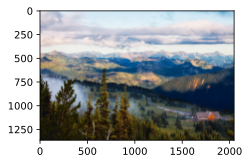

In [2]:
d2l.set_figsize()
content_img = d2l.Image.open('../img/rainier.jpg')
d2l.plt.imshow(content_img);

### Load the 'Style Img'

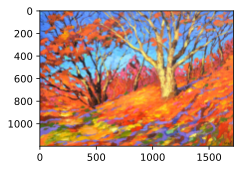

In [3]:
style_img = d2l.Image.open('../img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

### Preprocess and Postprocess

In [4]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    '''change a RGB img to a tensor for training'''
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
    ])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    '''change a tensor to a RGB img'''
    img = img[0].to(rgb_std.device)
    #  multiple std then add mean
    # then if num is larger than 1 then modify it to 1; if num is smaller than 0 then modify to 0
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1) 
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

### Extract Features

In [5]:
# the original paper chose the vgg19 as the backbone
pretrained_net = torchvision.models.vgg19(pretrained=True)

In [6]:
# style_layers means the layers are aimed to match the style
# content_layers means the layers are aimed to match the content
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
# bottom layers contain the detail information
# upper layers contain the morphing content

In [7]:
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])

In [33]:
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [11]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)   
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [12]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device) # change the content_img to tensor 
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)  # change the style_img to tensor
    _, styles_Y = extract_features(content_X, content_layers, style_layers)
    return style_X, styles_Y

### Define Loss Function

In [13]:
def content_loss(Y_hat, Y):
    '''content loss'''
    # y.detach() mean the net does not update, only the input updates
    return torch.square(Y_hat - Y.detach()).mean()  # get the square then get the mean

In [14]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)  # X * X.T is the Covariance matrix
                                                      # then divide (num_channels * n) to normalize

In [15]:
def style_loss(Y_hat, gram_Y):  # gt gram_Y we can compute at first
    '''style loss'''
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

In [16]:
# Keep the difference between a pixel and its 4 surrounding pixels small through abstract
def tv_loss(Y_hat): 
    '''total variantion loss to reduce noise'''
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() + 
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

In [22]:
content_weight, style_weight, tv_weight = 1, 1e4, 

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [
        content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(contents_Y_hat, contents_Y)
    ]  # iterate each layer to get the content_loss then multiple the its weight
    styles_l = [
        style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram)
    ]  # iterate each layer to get the style_loss then multiple the its weight
    tv_l = tv_loss(X) * tv_weight
    l = sum(styles_l + contents_l + [tv_l])  
    # ***try to change the style_weight to 1e4 not multiple the 10 at here
    return contents_l, styles_l, tv_l, l

### Initialize the Sythesized Img

In [23]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))  # this weight is belongs to the synthesized img 
                                                            # at first, just random initialize
        
    def forward(self):
        return self.weight    # now we can get the gradient of this weight then update

In [24]:
# we can choose content_X or style_X as the initialization value of X
def get_inits(X, device, lr, styles_Y):  
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)        # if new X is better, then overwrite the initialized X
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

### Train

In [25]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs],
                             legend=['content_loss', 'style_loss', 'TV_loss'], ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)), float(sum(styles_l)), float(tv_l)])
    return X

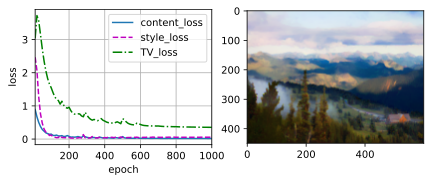

In [29]:
device, image_shape = d2l.try_gpu(), (450, 600)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.1, 1000, 100) # we choose to train from content_X